# Exploratory Data Analysis: Gene Ontology (GO) Graph

In the **first part** of this notebook, we introduce **basic operations **on graphs. In the **second part** we perform an **Exploratory Data Analysis (EDA)** of the Gene Ontology Directed Acyclic Multigraph.

**1. Basic operations on graphs:**
- Creating graphs
- Adding nodes and edges
- Adding graph, node and edge attributes
- Analyzing graph and node degrees
- Analyzing graph connectivity
- Vizualizing graphs

**2. Exploratory Data Analysis - Gene Ontology Graph**
- Reading and parsing GO graph data
- Analyzing graph and nodes' degrees
- Analyzing graph connectivity
- Extracting and visualizing nodes' attributes
- Visualizing the GO graph
- Spliting the GO graph into major sub-ontologies
- Extracting nodes' attributes into a dataframe

## Setting up the environment

In [1]:
# install required libraries (required for Colab, Kaggle)

# !pip install obonet networkx


In [2]:
# download GO graph data

# !wget https://purl.obolibrary.org/obo/go/go-basic.obo


In [3]:
# set home directory

from pathlib import Path

home_dir = Path("../GO-graph-EDA/")
print(f"Home dir: {home_dir.as_posix()}")

Home dir: ../GO-graph-EDA


In [4]:
# define custom functions

# plot graphs or sub-graphs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pylab import rcParams


def plot_graph(
    G: nx.Graph(),
    plot_nodes=list,
    plot_all=False,
    num_nodes=50,
    iterations=100,
    figure_size=(12, 12),
    node_color="green",
):
    """
    Plot the full graph (plot_all=True) or a sub-graph with the
    nodes passed as parameter. The 'n_terms' parameter controls
    how many nodes will be plotted in the top-down list of nodes.

    G: nx.Graph
    plot_nodes: list with the nodes to plot
    plot_all: select wheter plot the full graph or a subgraph
    n_nodes: number of nodes to plot
    iterations: number of iterations of spring_layout algorithm
    figure_size: tuple with figure dimensions (W x H)
    node_color: specify node color
    """
    if plot_all:
        n_nodes = len(G.nodes)
        n_edges = len(G.edges)
        print(f"Plotting full graph with {n_nodes} nodes and {n_edges} edges...")
    else:
        G = nx.subgraph(G, plot_nodes[:num_nodes])
        n_nodes = len(G.nodes)
        n_edges = len(G.edges)
        print(f"Plotting subgraph with {n_nodes} nodes and {n_edges} edges...")

    # set figure size
    rcParams["figure.figsize"] = figure_size

    # nodes features
    degree_dict = dict(G.degree)  # get degree to adjust node viz
    node_size = list([x * 100 for x in degree_dict.values()])
    node_alpha = [float(x / max(degree_dict.values())) for x in degree_dict.values()]

    pos = nx.spring_layout(
        G,
        scale=10,
        k=25 / np.sqrt(n_nodes),
        seed=13,
        iterations=iterations,
    )

    ax = nx.draw_networkx_nodes(
        G, pos, node_size=node_size, alpha=node_alpha, node_color=node_color
    )

    ax = nx.draw_networkx_edges(
        G, pos, width=0.5, node_size=node_size, edge_color="grey"
    )

    ax = nx.draw_networkx_labels(
        G,
        pos,
        font_size=10,
        font_color="grey",
        horizontalalignment="center",
        verticalalignment="center",
    )

    plt.show()


# convert list of tuples into Python dict type


def tuple_to_dict(t: tuple, d: dict):
    d = dict(t)
    return d


# plot histograms with the degree distribution of a graph


def plot_hist_degree(G: nx.Graph, bins=15):
    # retrieve nodes' degrees (GO term ID, degree)
    degree_desc = sorted(G.degree, key=lambda x: x[1], reverse=True)

    # converto into dict
    degree_desc_dict = {}
    degree_desc_dict = tuple_to_dict(degree_desc, degree_desc_dict)

    # plot degrees

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    fig.suptitle("GO Graph Degree Distribution")

    sns.histplot(ax=axs[0], data=degree_desc_dict.values(), bins=bins, legend=False)
    axs[0].set_title("Degree Distribution")
    axs[0].set_xlabel("Degree")

    sns.histplot(
        ax=axs[1],
        data=degree_desc_dict.values(),
        bins=bins,
        log_scale=True,
        legend=False,
    )
    axs[1].set_title("Log Degree Distribution")
    axs[1].set_xlabel("log(degree)")
    plt.show()


# print out topological generations


def print_generations(G: nx.DiGraph()):
    topo_gen_list = []
    to_insert = []
    for item_list in nx.topological_generations(G):
        to_insert = [
            item + " (" + G.nodes()[item]["namespace"] + ")" for item in item_list
        ]
        topo_gen_list.append(to_insert)

    # reverse the list of topological generations
    counter = len(topo_gen_list)
    for item in topo_gen_list:
        print(f"Generation {counter} -> {item}")
        counter -= 1

## Basic Operations on Graphs

To begin, we will create a directed acyclic graph (DAG), which is almost the same type of graph that the Gene Ontology Consortium uses to organise more than 40,000 GO terms. The difference is that the Gene Ontology graph can have multiple edges connecting the same two nodes and is defined as a Directed Acyclic Multigraph.

> For a detailed overview on creating and manipulating graphs, visit the [NetworkX documentation](https://networkx.org/).

### Creating graphs

To create an empty graph, we can simply instantiate one of the various classes of Networkx graphs. Let's create a directed graph using `networkx.DiGraph()`:

In [5]:
graph = nx.DiGraph()  # empty directed graph instance
type(graph)

networkx.classes.digraph.DiGraph

### Adding nodes and edges

The graph we have just created is empty. We will populate the graph with nodes and edges and add attributes to them later.

Nodes can be any kind of hashable object: lists, files, arrays, *tensors* (a special kind of *array*), functions, objects, etc. However, many frameworks for graph-based learning only accept a few types of objects and are also concise in their labelling of nodes and edges.

In [6]:
graph.add_node(1)  # add one node
graph.add_nodes_from([2, 3, 4, 5, 6, 7, 8])  # add 7 nodes
print(graph.nodes())
print(graph.edges())

[1, 2, 3, 4, 5, 6, 7, 8]
[]


Edges can be created by passing a tuple containing both nodes to be connected. For the sake of simplicity, we will work with graphs without self-loops in the examples below. Additionally, edges can possess weights that signify the importance of that connection in relation to other edges.

In the case of directed graphs, the order of the nodes within a tuple defines the direction (out-node, in-node) of the edge, which is represented by an arrow as shown in Figure 1. To incorporate weighted edges, simply include the weight as a third element in the tuple (out-node, in-node, weight).

In [7]:
graph.add_weighted_edges_from(
    [
        (2, 1, 1),
        (2, 3, 0.5),
        (4, 2, 1.0),
        (5, 2, 0.3),
        (5, 6, 0.1),
        (8, 6, 0.7),
        (8, 5, 0.7),
        (7, 5, 0.05),
    ]
)

# directed graphs have in-degree and out-degree of nodes
print(f"in edges: {graph.in_edges()}")
print(f"out edges: {graph.out_edges()}")


in edges: [(2, 1), (4, 2), (5, 2), (2, 3), (8, 5), (7, 5), (5, 6), (8, 6)]
out edges: [(2, 1), (2, 3), (4, 2), (5, 2), (5, 6), (7, 5), (8, 6), (8, 5)]


As an example of how nodes can store virtually any object, we will incorporate the graph we've just created as a node in another graph:

In [8]:
# create a undirected graph and add our graph as a node
nested_graph = nx.Graph()
nested_graph.add_node(graph)
nested_graph.add_node(nx.Graph())  #  an empty graph

# and the graphs in the nodes can be accessed as the usual object
for node in nested_graph.nodes():
    print(node)
    print(node.nodes())
    print(node.edges())
    print()

DiGraph with 8 nodes and 8 edges
[1, 2, 3, 4, 5, 6, 7, 8]
[(2, 1), (2, 3), (4, 2), (5, 2), (5, 6), (7, 5), (8, 6), (8, 5)]

Graph with 0 nodes and 0 edges
[]
[]



### Adding graph, node and edge attributes

Graphs, nodes and edges can contain additional data or information in **attributes**. These attributes help us characterise the graph and are useful in machine learning applications to train accurate models.

**Graph attributes:** Properties or information about the entire graph, e.g. name, type and other metadata that help characterise the graph.

**Node attributes:** Properties or characteristics of the individual nodes. Node attributes store characteristics that describe the node. In protein-protein interaction networks, these features may be the family of the protein, the embedded protein sequence, taxon information, etc. They enrich the information of the node and can be used in machine learning applications to improve the predictions of the models.

**Edge attributes:** Properties or characteristics of individual edges. Edge attributes can store weights (how important the connection between graph edges is) or the type of relationship between two nodes that the edge represents.

In [9]:
# passing a dictionary with node's attributes
node_attributes = {
    1: {"attribute_1": 3, "attribute_2": ["apples", "pineaples", "bananas"]},
    2: {"attribute_1": 2, "attribute_2": ["apples", "pineaples"]},
    3: {
        "attribute_1": 4,
        "attribute_2": ["apples", "pineaples", "strawberries", "bananas"],
    },
    4: {"attribute_1": 2, "attribute_2": ["apples", "bananas"]},
    5: {"attribute_1": 0, "attribute_2": []},
    6: {"attribute_1": 1, "attribute_2": ["apples"]},
    7: {"attribute_1": 4, "attribute_2": ["apples", "pineaples", "grapes", "oranges"]},
    8: {"attribute_1": 0, "attribute_2": []},
}

# set attributes
nx.set_node_attributes(graph, node_attributes)

# access attributes using node's
print(graph.nodes()[1])
print(graph.nodes()[2])
print(graph.nodes()[3])
print(graph.nodes()[4])
print()

# or iterates over nodes to print attributes
for label in graph.nodes():
    print(graph.nodes()[label])

{'attribute_1': 3, 'attribute_2': ['apples', 'pineaples', 'bananas']}
{'attribute_1': 2, 'attribute_2': ['apples', 'pineaples']}
{'attribute_1': 4, 'attribute_2': ['apples', 'pineaples', 'strawberries', 'bananas']}
{'attribute_1': 2, 'attribute_2': ['apples', 'bananas']}

{'attribute_1': 3, 'attribute_2': ['apples', 'pineaples', 'bananas']}
{'attribute_1': 2, 'attribute_2': ['apples', 'pineaples']}
{'attribute_1': 4, 'attribute_2': ['apples', 'pineaples', 'strawberries', 'bananas']}
{'attribute_1': 2, 'attribute_2': ['apples', 'bananas']}
{'attribute_1': 0, 'attribute_2': []}
{'attribute_1': 1, 'attribute_2': ['apples']}
{'attribute_1': 4, 'attribute_2': ['apples', 'pineaples', 'grapes', 'oranges']}
{'attribute_1': 0, 'attribute_2': []}


In [10]:
# passing a dictionary with edges's attributes
edge_attributes = {
    (2, 1): {"attribute": "is_a"},
    (2, 3): {"attribute": "regulates"},
    (4, 2): {"attribute": "activates"},
    (5, 2): {"attribute": "a random relation"},
    (5, 6): {"attribute": "is_a"},
    (7, 5): {"attribute": "deactivates"},
    (8, 6): {"attribute": "unknown"},
    (8, 5): {"attribute": "kick"},
}

# set attributes
nx.set_edge_attributes(graph, edge_attributes)

# iterates over nodes to print attributes
for label in graph.edges():
    print(graph.edges()[label])


{'weight': 1, 'attribute': 'is_a'}
{'weight': 0.5, 'attribute': 'regulates'}
{'weight': 1.0, 'attribute': 'activates'}
{'weight': 0.3, 'attribute': 'a random relation'}
{'weight': 0.1, 'attribute': 'is_a'}
{'weight': 0.05, 'attribute': 'deactivates'}
{'weight': 0.7, 'attribute': 'unknown'}
{'weight': 0.7, 'attribute': 'kick'}


To effectively represent the edges of a graph in a computer-readable format, we have two widely used options: the **list of edges** and **adjacency matrices**. The list of edges stands out as a more streamlined choice when compared to adjacency matrices. The latter, while comprehensive, can prove computationally demanding when dealing with large networks. Furthermore, it's crucial to recognize that real-world networks often exhibit sparsity, leading to adjacency matrices filled with numerous empty or zero entries. Therefore, opting for a list of edges is the recommended approach.

However, it's worth noting that adjacency matrices come with their own advantages. They facilitate operations on graphs, such as determining degrees and connectivity.

In the code cell below, we present the **list of edges** for our graph:

In [11]:
for item in nx.to_edgelist(graph):
    print(item)


(2, 1, {'weight': 1, 'attribute': 'is_a'})
(2, 3, {'weight': 0.5, 'attribute': 'regulates'})
(4, 2, {'weight': 1.0, 'attribute': 'activates'})
(5, 2, {'weight': 0.3, 'attribute': 'a random relation'})
(5, 6, {'weight': 0.1, 'attribute': 'is_a'})
(7, 5, {'weight': 0.05, 'attribute': 'deactivates'})
(8, 6, {'weight': 0.7, 'attribute': 'unknown'})
(8, 5, {'weight': 0.7, 'attribute': 'kick'})


The **adjacency matrix** is a square matrix in which connections between two nodes are represented as '1', while '0' indicates that the nodes are not connected. In the case of weighted graphs, connected nodes are denoted by real numbers, representing the weight of the connection.

NetworkX offers a range of functions for displaying the adjacency matrix. One particularly noteworthy function is `networkx.to_pandas_adjacency()` , which generates a Pandas dataframe presenting the matrix visualization familiar to us. The nodes are mirrored in both the row and column labels. In the adjacency matrix of our weighted graph is shown below (unweighted graphs have 'ones' instead of weights):

In [12]:
graph_adj = nx.to_pandas_adjacency(graph)
graph_adj

,1,2,3,4,5,6,7,8
1,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
2,1.0,0.0,0.5,0.0,0.00,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0
5,0.0,0.3,0.0,0.0,0.00,0.1,0.0,0.0
6,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.70,0.7,0.0,0.0


### Analyzing graph and node degrees

The degree of a node is determined by the number of edges connected to it. In the context of directed graphs, like the GO graph, we define *in-degree* as the total count of edges arriving at the node, and *out-degree* as the total count of edges departing from the node (the *direction* is visually represented by an *arrow*). In this scenario, a node's degree is the sum of its *in-degree* and *out-degree*. In undirected networks, where edges are bidirectional, the degree simply corresponds to the number of edges connected to the node.

In [13]:
# iterates over edges to print degrees
print("Degrees:")
for node in graph.nodes():
    print(
        f"Node: {node}, out-degree: {graph.out_degree(node)}, in-degree: {graph.in_degree(node)}, degree: {graph.degree(node)}"
    )


Degrees:
Node: 1, out-degree: 0, in-degree: 1, degree: 1
Node: 2, out-degree: 2, in-degree: 2, degree: 4
Node: 3, out-degree: 0, in-degree: 1, degree: 1
Node: 4, out-degree: 1, in-degree: 0, degree: 1
Node: 5, out-degree: 2, in-degree: 2, degree: 4
Node: 6, out-degree: 0, in-degree: 2, degree: 2
Node: 7, out-degree: 1, in-degree: 0, degree: 1
Node: 8, out-degree: 2, in-degree: 0, degree: 2


In the case of weighted graphs, we can calculate the *weighted node degree*:

In [14]:
# iterates over edges to print weighted degrees
print("Weighted degrees:")
for node in graph.nodes():
    print(
        f"Node: {node}, out-degree: {graph.out_degree(node, weight='weight')}, in-degree: {graph.in_degree(node, weight='weight')}, degree: {graph.degree(node, weight='weight')}"
    )


Weighted degrees:
Node: 1, out-degree: 0, in-degree: 1, degree: 1
Node: 2, out-degree: 1.5, in-degree: 1.3, degree: 2.8
Node: 3, out-degree: 0, in-degree: 0.5, degree: 0.5
Node: 4, out-degree: 1.0, in-degree: 0, degree: 1.0
Node: 5, out-degree: 0.4, in-degree: 0.75, degree: 1.15
Node: 6, out-degree: 0, in-degree: 0.7999999999999999, degree: 0.7999999999999999
Node: 7, out-degree: 0.05, in-degree: 0, degree: 0.05
Node: 8, out-degree: 1.4, in-degree: 0, degree: 1.4


### Analyzing graph connectivity

Connectivity measures how connected are the nodes in the graph, indicating the ability to traverse the graph from one node to another through the edges. An interesting example is a graph of transportation routes: the connectivity indicates the reachability of addresses within the graph. In social networks, we can use connectivity measures to determine the difusion of information and detect communities withing the network. Some connectivity measures are:

- **Strong connectivity**: every node is reachable from any other node
- **Weak connectivity Graph**: the graph is connected disregarding edges' directions
- **Semi-connectivity**: either node is reachable from the other, or mutually reachable

In [15]:
print(f"Is Directed Acyclic Graph?: {nx.is_directed_acyclic_graph(graph)}")
print(f"Is Directed Acyclic Multigraph?: {graph.is_multigraph()}")


Is Directed Acyclic Graph?: True
Is Directed Acyclic Multigraph?: False


In [16]:
print(
    f"Number of connected components: {nx.number_strongly_connected_components(graph)}"
)
print(f"Strongly connected?: {nx.is_strongly_connected(graph)}")
print(f"Semiconnected?: {nx.is_semiconnected(graph)}")
print(f"Weakly connected?: {nx.is_weakly_connected(graph)}")

Number of connected components: 8
Strongly connected?: False
Semiconnected?: False
Weakly connected?: True


To visualize the graph, we shall employ our custom plotting function to assess its structure. While visualizing small graphs proves insightful, this approach becomes infeasible when dealing with larger graphs. In such scenarios, we can select a subset of nodes and edges, enabling the focused visualization of specific node groups and their interconnections.

Plotting full graph with 8 nodes and 8 edges...


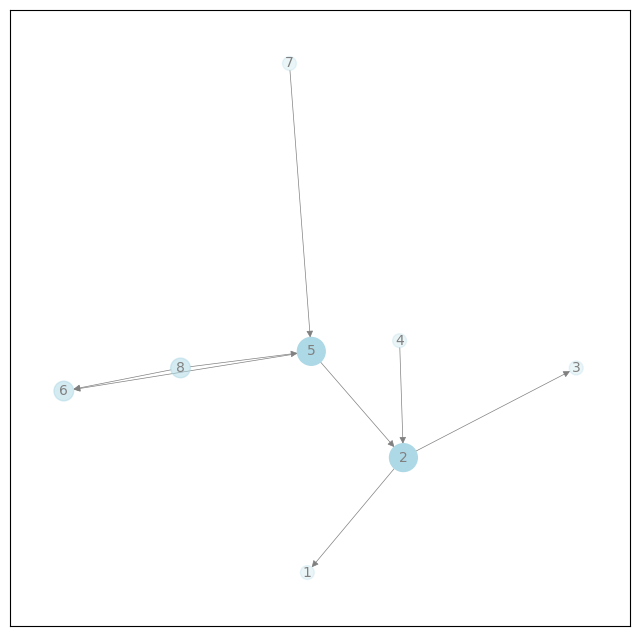

In [17]:
# plot graph -> node size and transparency: degree

plot_graph(
    graph, plot_all=True, iterations=1000, figure_size=(8, 8), node_color="lightblue"
)

In a directed cyclic graph, nodes can be categorized as either **ancestors** or **descendants**. An ancestor of a node *v* is a distinct node *u* from which we can trace a direct path leading to *v*. Conversely, node *v* is considered a descendant of node *u* in this context. Therefore, ancestors and descendants are positioned along a linear path, with ancestors preceding descendants in the graph's structure.

Ancestors of node 2: {8, 4, 5, 7}
Descendants of node 2: {1, 3}
Plotting subgraph with 5 nodes and 4 edges...


/tmp/ipykernel_23468/423549382.py:63: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  ax = nx.draw_networkx_edges(


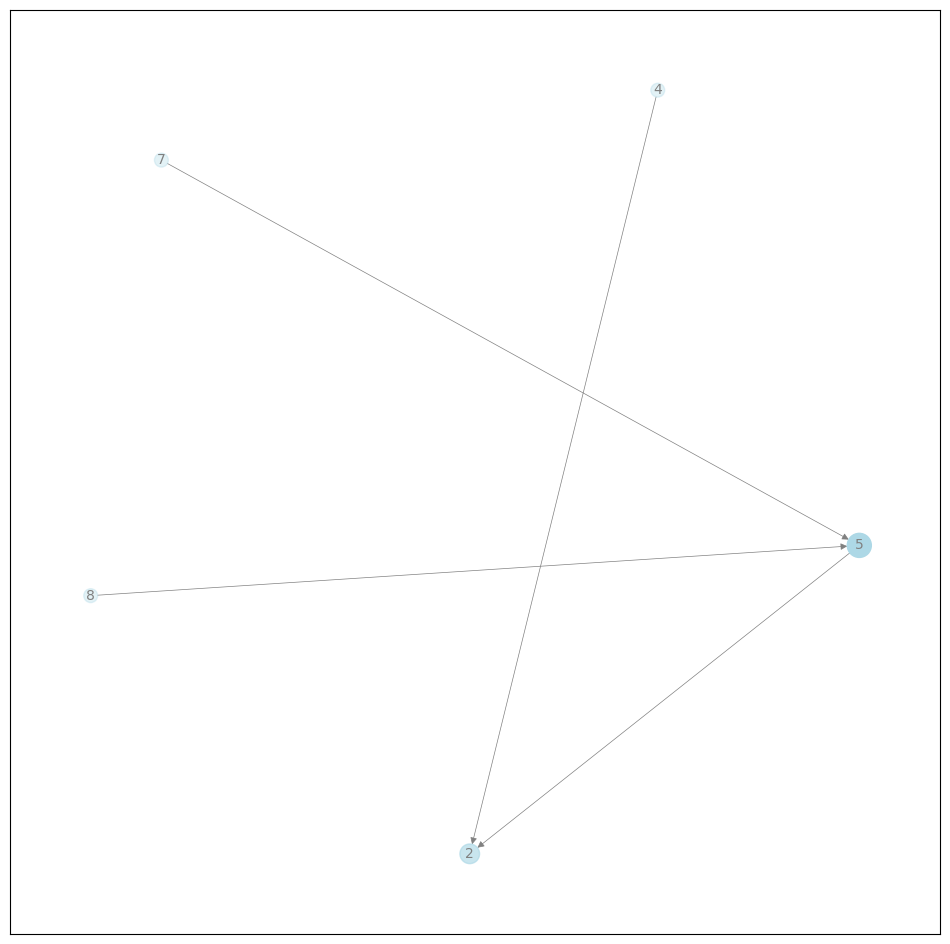

Plotting subgraph with 3 nodes and 2 edges...


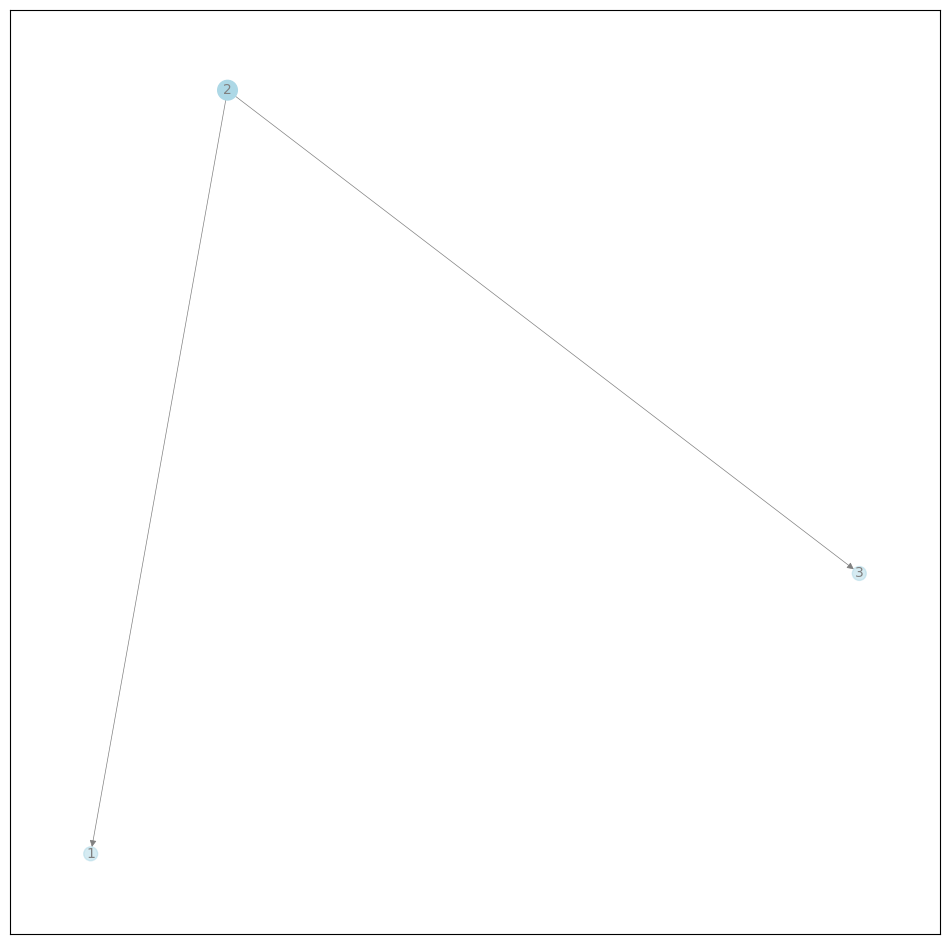

In [18]:
print(f"Ancestors of node 2: {nx.ancestors(graph, 2)}")
print(f"Descendants of node 2: {nx.descendants(graph, 2)}")

# plot ancestors of node 2
plot_graph(
    graph, plot_all=False, plot_nodes=[2, 8, 4, 5, 7], node_color="lightblue"
)

# plot descendants of node 2
plot_graph(graph, plot_all=False, plot_nodes=[2, 1, 3], node_color="lightblue")

it is possible to partition the directed graph into distinct layers known as **topological generations**. This process involves applying a topological sorting algorithm to the nodes in such a manner that a node within a given generation is guaranteed to have its ancestors located in the previous generation.

In [19]:
counter = 1
for item in nx.topological_generations(graph):
    print(f"Generation {counter}: {item}")
    counter += 1


Generation 1: [4, 7, 8]
Generation 2: [5]
Generation 3: [2, 6]
Generation 4: [1, 3]


Another interesting aspect of graphs is finding the **longest path between two nodes**. In graphs where edges have weights, we calculate the longest path by considering the **weighted node degree**. This essentially means adding up the importance of all the connections a node has.

In [20]:
print(
    f"Longest path of weighted graph: {nx.dag_longest_path(graph)} (lenght={len(nx.dag_longest_path(graph)) - 1})"
)

Longest path of weighted graph: [4, 2, 1] (lenght=2)


Removing the weights, the longest path between two nodes is the number of edges in the path between them.

In [21]:
# removing weights to calculate the longest path of an un-weighted graph

# copy a version of the original weighted graph
graph_unweighted = graph.copy()

# print out edges' attributes
print("Weighted edges' attributes:")
for label in graph_unweighted.edges():
    print(graph_unweighted.edges()[label])

# remove weights by accessing the graph data structure
for node, edges in nx.to_dict_of_dicts(graph_unweighted).items():
    for (
        edge,
        attrs,
    ) in edges.items():
        attrs.pop("weight", None)

print()

# print out edges' attributes (no weights)
print("Unweighted edges' attributes:")
for label in graph_unweighted.edges():
    print(graph_unweighted.edges()[label])


print(
    f"\nLongest path of unweighted graph: {nx.dag_longest_path(graph_unweighted)} (lenght={len(nx.dag_longest_path(graph_unweighted)) - 1})"
)

Weighted edges' attributes:
{'weight': 1, 'attribute': 'is_a'}
{'weight': 0.5, 'attribute': 'regulates'}
{'weight': 1.0, 'attribute': 'activates'}
{'weight': 0.3, 'attribute': 'a random relation'}
{'weight': 0.1, 'attribute': 'is_a'}
{'weight': 0.05, 'attribute': 'deactivates'}
{'weight': 0.7, 'attribute': 'unknown'}
{'weight': 0.7, 'attribute': 'kick'}

Unweighted edges' attributes:
{'attribute': 'is_a'}
{'attribute': 'regulates'}
{'attribute': 'activates'}
{'attribute': 'a random relation'}
{'attribute': 'is_a'}
{'attribute': 'deactivates'}
{'attribute': 'unknown'}
{'attribute': 'kick'}

Longest path of unweighted graph: [7, 5, 2, 1] (lenght=3)


## Exploratory Data Analysis - Gene Ontology Graph

### Reading and parsing GO graph data

The GO graph is available in the *OBO format*, a biology-oriented way to build and represent ontologies. To read and to parse the GO graph we can use the Python library *obonet* to return a NetworkX object with all the awesome functionalies to manipulate and analyze graphs. 

Below we load and parse the GO graph to print out some its basic features:

In [22]:
from obonet import read_obo

go_graph = read_obo(home_dir.joinpath("go-basic.obo"))
print(type(go_graph))


<class 'networkx.classes.multidigraph.MultiDiGraph'>


In [23]:
print(f"Is Directed Acyclic Graph (DAG)?: {nx.is_directed_acyclic_graph(go_graph)}")
print(f"Is MultiGraph (multiple edges between two nodes)?: {go_graph.is_multigraph()}")
print(f"Is weighted graph: {nx.is_weighted(go_graph)}")
print(f"Number of Nodes: {go_graph.order()}")
print(f"Number of Edges: {go_graph.size()}")

Is Directed Acyclic Graph (DAG)?: True
Is MultiGraph (multiple edges between two nodes)?: True
Is weighted graph: False
Number of Nodes: 43248
Number of Edges: 84805


### Analyzing graph and nodes' degrees

The degree of each node is stored in a dictionary-like structure that can be retrieved as a list of tuples (GO term, degree) using the handy Python's list comprehension. Let's sort the nodes by descending order of degree. We use a lambda function to pass the node's degree as key for sorting and return an ordered list of tuples *(GO term, degree)*. 
Bellow we sort *in* and *out* degrees of the GO graph:

In [24]:
# print out degrees of top in-degree nodes
go_term_in_desc = sorted(go_graph.in_degree(),
                         key=lambda x: x[1], reverse=True)

print("Degrees:\n")
for term in go_term_in_desc[:11]:  # print top10
    print(
        f"Node: {term[0]}, in-degree: {go_graph.in_degree(term[0])}, out-degree: {go_graph.out_degree(term[0])}, degree: {go_graph.degree(term[0])}"
    )


Degrees:

Node: GO:0110165, in-degree: 424, out-degree: 1, degree: 425
Node: GO:0016616, in-degree: 348, out-degree: 1, degree: 349
Node: GO:0016709, in-degree: 291, out-degree: 2, degree: 293
Node: GO:0032991, in-degree: 274, out-degree: 1, degree: 275
Node: GO:0016758, in-degree: 208, out-degree: 1, degree: 209
Node: GO:0048856, in-degree: 202, out-degree: 1, degree: 203
Node: GO:0098797, in-degree: 181, out-degree: 2, degree: 183
Node: GO:0140513, in-degree: 173, out-degree: 2, degree: 175
Node: GO:0003006, in-degree: 172, out-degree: 2, degree: 174
Node: GO:0016747, in-degree: 163, out-degree: 1, degree: 164
Node: GO:0016836, in-degree: 158, out-degree: 1, degree: 159


In [25]:
# print out degrees of top in-degree nodes
go_term_out_desc = sorted(go_graph.out_degree(),
                          key=lambda x: x[1], reverse=True)
for term in go_term_out_desc[:11]:  # print top10
    print(
        f"Node: {term[0]}, in-degree: {go_graph.in_degree(term[0])}, out-degree: {go_graph.out_degree(term[0])}, degree: {go_graph.degree(term[0])}"
    )


Node: GO:0106110, in-degree: 0, out-degree: 11, degree: 11
Node: GO:0140872, in-degree: 0, out-degree: 10, degree: 10
Node: GO:0060520, in-degree: 0, out-degree: 9, degree: 9
Node: GO:1900498, in-degree: 0, out-degree: 9, degree: 9
Node: GO:1900499, in-degree: 0, out-degree: 9, degree: 9
Node: GO:0000514, in-degree: 0, out-degree: 8, degree: 8
Node: GO:0009102, in-degree: 0, out-degree: 8, degree: 8
Node: GO:0010439, in-degree: 0, out-degree: 8, degree: 8
Node: GO:0034223, in-degree: 0, out-degree: 8, degree: 8
Node: GO:0042367, in-degree: 0, out-degree: 8, degree: 8
Node: GO:0043642, in-degree: 0, out-degree: 8, degree: 8


Analyzing the degree distribution of the network is a good start to get insight on how to use the network for useful applications.

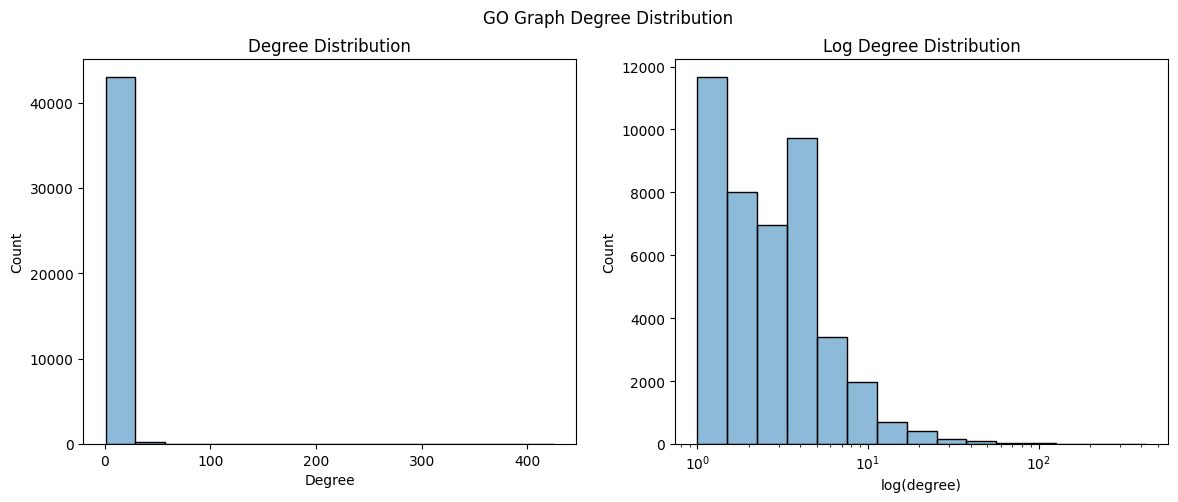

In [26]:
plot_hist_degree(go_graph, bins=15)


The degree's distribution is skewed to the left, indicating that most of the nodes have a relatively small degree. This is expected in the case of the GO graph because the GO graph is a tree.

In real-world networks, the majority of the nodes have just a few neighbors, while there is a small number of high-degree nodes referred as ***hubs***. Hubs are highly connected nodes and can be seen as the most accessed sites on the internet, or celebrities in social networks.

We also define the *average degree* of the network, a general property of graphs that indicates how connected their nodes are. For example, in two social networks with the same number of nodes, the one with higher average degree indicates that people in the network have more friends on average.

We can use `G.size()` and `G.order()` to obtain the number of edges and nodes, respectively. 

In [27]:
print(f"GO graph average degree: {(go_graph.size() / go_graph.order()):.2f}")


GO graph average degree: 1.96


The average degree of the GO graph is ~2, indicating that the average number of edges per node is small. However, we see above that there are some large hubs while more than 50% of the nodes have degree 3 or less. Inspecting such nodes can be informative for machine learning tasks because they tend to influence more the prediction of new nodes or edges.

In [28]:
from itertools import islice

# get GO degrees into a dict
go_degree_desc_dict = {}
go_degree_desc_dict = tuple_to_dict(
    sorted(go_graph.degree, key=lambda x: x[1],
           reverse=True), go_degree_desc_dict
)

# getting only top nodes
top_nodes_dict = dict(islice(go_degree_desc_dict.items(), 6))

# and print the GO term names

term_list = []  # keeping the terms to get their neighborhood later

for key, value in top_nodes_dict.items():
    term_list.append(key)
    print(
        f"{key} ({go_graph.nodes()[key]['namespace']}) --> {go_graph.nodes()[key]['name']}"
    )

print(f"\nTop degree list: {term_list}")


GO:0110165 (cellular_component) --> cellular anatomical entity
GO:0016616 (molecular_function) --> oxidoreductase activity, acting on the CH-OH group of donors, NAD or NADP as acceptor
GO:0016709 (molecular_function) --> oxidoreductase activity, acting on paired donors, with incorporation or reduction of molecular oxygen, NAD(P)H as one donor, and incorporation of one atom of oxygen
GO:0032991 (cellular_component) --> protein-containing complex
GO:0016758 (molecular_function) --> hexosyltransferase activity
GO:0048856 (biological_process) --> anatomical structure development

Top degree list: ['GO:0110165', 'GO:0016616', 'GO:0016709', 'GO:0032991', 'GO:0016758', 'GO:0048856']


These parent terms have broad definitions about the type of cellular compartments, biological processes and molecular functions they describe. As we move from parents to children terms we also narrow down more specific definitions. 

We can list all neighbors of a specific node. For directed graphs, the neighbors of a node are all of tis incoming and outcoming edges. Lets see the neighborhood of these terms that can be found at ***one-hop*** distance (i.e. the immediate neighboring nodes).

In [29]:
hub = "GO:0032991"  # molecular function: oxidoreductase activity
hub_neighbors = [n for n in nx.all_neighbors(go_graph, hub)]

# extract sub-graph with the neighboring nodes and get degrees in descending order
neighbors_desc = sorted(
    nx.subgraph(go_graph, set(hub_neighbors)).degree, key=lambda x: x[1], reverse=True
)

# print parent and child terms in descending order of degree
print(
    f"Neighbors of {hub} ({go_graph.nodes()[hub]['name']}) in descending order of degree:\n"
)

for term in neighbors_desc[:25]:  # top 25
    print(
        f"{term[0]} (degree: {term[1]}) --> {go_graph.nodes()[term[0]]['name']}")


Neighbors of GO:0032991 (protein-containing complex) in descending order of degree:

GO:0022624 (degree: 3) --> proteasome accessory complex
GO:0005838 (degree: 3) --> proteasome regulatory particle
GO:0030990 (degree: 2) --> intraciliary transport particle
GO:0000939 (degree: 2) --> inner kinetochore
GO:0001534 (degree: 2) --> radial spoke
GO:0035859 (degree: 2) --> Seh1-associated complex
GO:0043493 (degree: 1) --> viral terminase complex
GO:0030991 (degree: 1) --> intraciliary transport particle A
GO:0000444 (degree: 1) --> MIS12/MIND type complex
GO:0008537 (degree: 1) --> proteasome activator complex
GO:0097710 (degree: 1) --> viral terminase, small subunit
GO:0001536 (degree: 1) --> radial spoke stalk
GO:0061700 (degree: 1) --> GATOR2 complex
GO:1990130 (degree: 1) --> GATOR1 complex
GO:0031511 (degree: 1) --> Mis6-Sim4 complex
GO:0008540 (degree: 1) --> proteasome regulatory particle, base subcomplex
GO:0031262 (degree: 1) --> Ndc80 complex
GO:0001535 (degree: 1) --> radial spok

Note that high-degree child nodes (*cytoplasm*, *cell projection*, *extracelullar region*, etc) are still broad biological definitions. For example, in the *extracelullar region* we have parent neighbors (*celullar anatomical entity*) and child terms that narrow the definitions of the extracellular region:

In [30]:
hub = "GO:0022624"
hub_neighbors = [n for n in nx.all_neighbors(go_graph, hub)]

# extract sub-graph with the neighboring nodes and get degrees in descending order
neighbors_desc = sorted(
    nx.subgraph(go_graph, set(hub_neighbors)).degree, key=lambda x: x[1], reverse=True
)

# print parent and child terms in descending order of degree
print(
    f"Neighbors of {hub} ({go_graph.nodes()[hub]['name']}) in descending order of degree:\n"
)

for term in neighbors_desc:
    print(f"{term[0]} (degree: {term[1]}) --> {go_graph.nodes()[term[0]]}")


Neighbors of GO:0022624 (proteasome accessory complex) in descending order of degree:

GO:0032991 (degree: 3) --> {'name': 'protein-containing complex', 'namespace': 'cellular_component', 'alt_id': ['GO:0043234'], 'def': '"A stable assembly of two or more macromolecules, i.e. proteins, nucleic acids, carbohydrates or lipids, in which at least one component is a protein and the constituent parts function together." [GOC:dos, GOC:mah]', 'comment': 'A protein complex in this context is meant as a stable set of interacting proteins which can be co-purified by an acceptable method, and where the complex has been shown to exist as an isolated, functional unit in vivo. Acceptable experimental methods include stringent protein purification followed by detection of protein interaction. The following methods should be considered non-acceptable: simple immunoprecipitation, pull-down experiments from cell extracts without further purification, colocalization and 2-hybrid screening. Interactions th

### Analyzing graph connectivity

Checking if the GO graph is strongly connected, semiconnected or weakly connected:

We can obtain the list of edges, which is a convenient way to store edges in large graphs such as the GO graph. We might want to save the edges' list and print out the first entries because the GO graph have thousands of edges:

In [31]:
go_edges_list = []
for item in nx.to_edgelist(go_graph):
    go_edges_list.append(item)

go_edges_list[:15]


[('GO:0000001', 'GO:0048308', {}),
 ('GO:0000001', 'GO:0048311', {}),
 ('GO:0000002', 'GO:0007005', {}),
 ('GO:0000003', 'GO:0008150', {}),
 ('GO:0000006', 'GO:0005385', {}),
 ('GO:0000007', 'GO:0005385', {}),
 ('GO:0000009', 'GO:0000030', {}),
 ('GO:0000010', 'GO:0004659', {}),
 ('GO:0000011', 'GO:0007033', {}),
 ('GO:0000011', 'GO:0048308', {}),
 ('GO:0000012', 'GO:0006281', {}),
 ('GO:0000014', 'GO:0004520', {}),
 ('GO:0000015', 'GO:1902494', {}),
 ('GO:0000015', 'GO:0005829', {}),
 ('GO:0000016', 'GO:0004553', {})]

In [32]:
nx.dag_longest_path(go_graph)


['GO:0090687',
 'GO:1905326',
 'GO:1905325',
 'GO:1905318',
 'GO:0033316',
 'GO:0044779',
 'GO:1902103',
 'GO:1902102',
 'GO:1905132',
 'GO:0051307',
 'GO:0045132',
 'GO:0140013',
 'GO:0000280',
 'GO:0048285',
 'GO:0006996',
 'GO:0016043',
 'GO:0071840',
 'GO:0009987',
 'GO:0008150']

In [33]:
print(
    f"Number of connected components: {nx.number_strongly_connected_components(go_graph)}"
)
print(f"Strongly connected?: {nx.is_strongly_connected(go_graph)}")
print(f"Semiconnected?: {nx.is_semiconnected(go_graph)}")
print(f"Weakly connected?: {nx.is_weakly_connected(go_graph)}")

Number of connected components: 43248
Strongly connected?: False
Semiconnected?: False
Weakly connected?: False


That's very cool. These graph features are easily available, and the navigation throughout the network is quite straightforward because of the concise and clear data structures. Additionally, the data structures use standard python libraries with little modifications and easy conversion between types with just a few lines of code.

In the next tutorial, we will extract the definition (*'def'*) of each GO term to use as input into a pre-trained Large Language Model (LLM) to enrich nodes' features with a vector containing the embedding of its definition. The motivation is that the approach could capture key information to better define each GO term in classification tasks.

As a bonus, we will also use the <font color="blue">GO term definition's embedding</font> to map the extracted features into a manifold using T-SNE () to verify if the the embeddings could be sufficient to define as part of the major sub-ontologies <font color="blue">(Cellular Compartiment - CC, Biological Process (BP) and Molecular Function (MF))</font>.

### Ancestors and Descendants

GO terms can have parents and children terms. In network science, they are named *ancestors* and *descendants*. The functions to retrieve these nodes use the later terminology. Let's print out the ancestors and descendants of the GO term GO:0110165

In [34]:
ancestors = nx.ancestors(go_graph, hub)
descendants = nx.descendants(go_graph, hub)

print(f"Ancestors of {hub}:")
for term in ancestors:
    print(f"{term} --> {go_graph.nodes()[term]}")

print(f"\nDescendants of {hub}:")
for term in descendants:
    print(f"{term} --> {go_graph.nodes()[term]}")

Ancestors of GO:0022624:
GO:0031615 --> {'name': 'cytosolic proteasome regulatory particle, lid subcomplex', 'namespace': 'cellular_component', 'def': '"The subcomplex of the cytosolic proteasome regulatory particle that forms the peripheral lid, which is added on top of the base subcomplex." [GOC:mah, GOC:mtg_sensu]', 'is_a': ['GO:0008541'], 'relationship': ['part_of GO:0031600']}
GO:0008537 --> {'name': 'proteasome activator complex', 'namespace': 'cellular_component', 'def': '"A multisubunit complex that activates the hydrolysis of small nonubiquitinated peptides by binding to the proteasome core complex." [GOC:rb]', 'synonym': ['"PA28" NARROW []'], 'is_a': ['GO:0032991'], 'relationship': ['part_of GO:0022624']}
GO:0022623 --> {'name': 'proteasome-activating nucleotidase complex', 'namespace': 'cellular_component', 'def': '"A homohexameric complex that recognizes and unfolds core proteasome substrate proteins, and translocates them to the core complex in an ATP dependent manner." [G

### Topological Generations

The GO graph can be estratified into **topological generations** because it is a directed acyclic graph. As we've seen above, there are actually three major sub-ontologies in the GO graph that can be separated into three different trees. Each sub-ontology is the root of all descendants encompassing its descendants. In the code cell below, we obtain the topological generations of the entire GO graph and print out the items followed by the sub-ontology. The terms in *Generation 19* are guaranted to have the ancestors in the previous generations, thought terms can skip generations.

The output resembles the [ancestor chart](https://www.ebi.ac.uk/sites/ebi.ac.uk/files/groups/uniprot/posters/QuickGo_Biocuration.pdf) available in [QuickGo](https://www.ebi.ac.uk/QuickGO/annotations). Note that the most basal generation is the broadest term of the complete GO graph. Later we will obtain the generations of each major sub-ontology.

In [ ]:
print_generations(go_graph)


### Path Lenght

The estratified topological generations above is useful because we can get a glimpse of how the graph tree is organized into parents and childrens' terms. We can also define the **longest path lenght** in the tree, i.e., the path with the terms encompassing the longest chain of ancestors-descendants in the graph. Since we have 19 generations in the GO graph, we expect that the longest path has (Generation - 1) edges.

In [52]:
print("GO terms in the longest path (order: terminal leaves -> root):")
print(f"Path length: {nx.dag_longest_path_length(go_graph)}\n")

for item in nx.dag_longest_path(go_graph):
    print(
        f"Name: {go_graph.nodes()[item]['name']} | Ontology: {go_graph.nodes()[item]['namespace']}"
    )

GO terms in the longest path (order: terminal leaves -> root):
Path length: 18

Name: activation of meiosis I spindle assembly checkpoint | Ontology: biological_process
Name: positive regulation of meiosis I spindle assembly checkpoint | Ontology: biological_process
Name: regulation of meiosis I spindle assembly checkpoint | Ontology: biological_process
Name: meiosis I spindle assembly checkpoint signaling | Ontology: biological_process
Name: meiotic spindle assembly checkpoint signaling | Ontology: biological_process
Name: meiotic spindle checkpoint signaling | Ontology: biological_process
Name: negative regulation of metaphase/anaphase transition of meiotic cell cycle | Ontology: biological_process
Name: regulation of metaphase/anaphase transition of meiotic cell cycle | Ontology: biological_process
Name: regulation of meiotic chromosome separation | Ontology: biological_process
Name: meiotic chromosome separation | Ontology: biological_process
Name: meiotic chromosome segregation | 

### Nodes' Attributtes

The nodes' attributes of the GO graph store information about the term. Let's print out the attributes of a random node (seriously...). Keep running the cell to explore the GO graph node-per-node :-)

In [37]:
import random

go_graph.nodes()[random.choice([x for x in go_graph.nodes()])]


{'name': 'integrin alphaIIb-beta3 complex',
 'namespace': 'cellular_component',
 'def': '"An integrin complex that comprises one alphaIIb subunit and one beta3 subunit." [PMID:12297042]',
 'synonym': ['"alphaIIb-beta3 integrin complex" EXACT []',
  '"ITGA2B-ITGB3 complex" NARROW [CORUM:2381]'],
 'is_a': ['GO:0008305']}

In the node's attributes we can see some interesting features underlying each GO term. Here is a brief explanation about the essential GO term elements to describe and identify each GO term.

The *name* is a unique identifier of the term in a human-readable format.

The *namespace* is one of the three sub-ontologies aspects to which the term belongs:

- <font color="grey">***Molecular Function (MF)***</font>: specify the activities performed by the gene product, which can be "catalysis", "transport". These functions can be narrowed in more specific GO terms. "protein kinase activity" is more specific than just "catalysis"


- <font color="grey">***Cellular Component (CC)***</font>: locate the subcellular location of the gene product, which encompass compartments (e.g. 'chloroplast', 'nucleus') or macromolecular complexes such as the 'proteasome' or 'ribosome'.


- <font color="grey">***Biological Process (BP)***</font>: establish the pathway, or the molecular program, in which the gene product is involved to sustain organism's activities. Examples are 'DNA repair', 'carbohydrate metabolic process', or more general processes such as 'byosynthetic process'.

The *definition* ('def') is a concise short description of  what the GO term means for humans. It can also contains references to publications defining the term (e.g. PMID:10873824).

Finally, the *relations* between GO terms is given by keys such as *'is_a'*, or *'regulates'*. It is a GO representation of how two entities (remember, nodes are entities ) interact. There are other types of relations and we can bear in mind that the list of GO terms and the types of relations can grow overtime to accomodate precise definitions of new processes or new nuances regarding gene product's activities.

There are many additional attributes determined by the Gene Ontology Consortium, but the above ones are required to properly identify the GO term. By running the cell a couple of times you will see that the number of attributes vary but the four explained above are always there.


### GO Graph Ontologies (Celullar Compartment, Biological Process, Molecular Function)

We can split the GO graph into three sub-graphs corresponding to the major sub-ontologies. I did it by iterating over two 'carbon-copies' of the entire GO graph and removing nodes from the copy using a conditional statement. Maybe there is an way easier way but I couldn't find it.

In [38]:
# initialize sub-ontologies graphs by copying the entire GO graph
go_graph_cc = go_graph.copy()
go_graph_bp = go_graph.copy()
go_graph_mf = go_graph.copy()

# CC
for term in go_graph.nodes():
    if go_graph.nodes()[term]["namespace"] != "cellular_component":
        go_graph_cc.remove_node(term)

# BP
for term in go_graph.nodes():
    if go_graph.nodes()[term]["namespace"] != "biological_process":
        go_graph_bp.remove_node(term)

# MF
for term in go_graph.nodes():
    if go_graph.nodes()[term]["namespace"] != "molecular_function":
        go_graph_mf.remove_node(term)


print(f"CC sub-graph --> nodes: {go_graph_cc.order()}, edges: {go_graph_cc.size()}")
print(f"BP sub-graph --> nodes: {go_graph_bp.order()}, edges: {go_graph_bp.size()}")
print(f"MF sub-graph --> nodes: {go_graph_mf.order()}, edges: {go_graph_mf.size()}")

CC sub-graph --> nodes: 4043, edges: 6498
BP sub-graph --> nodes: 27942, edges: 64560
MF sub-graph --> nodes: 11263, edges: 13747


With these counts of nodes and edges we can infer some interesting insights. We can check the average degrees and rank nodes' degrees in each graph. This will allow us to determine their hubs considering only one sub-ontolgy at a time.

CC sub-graph average degree: 1.61


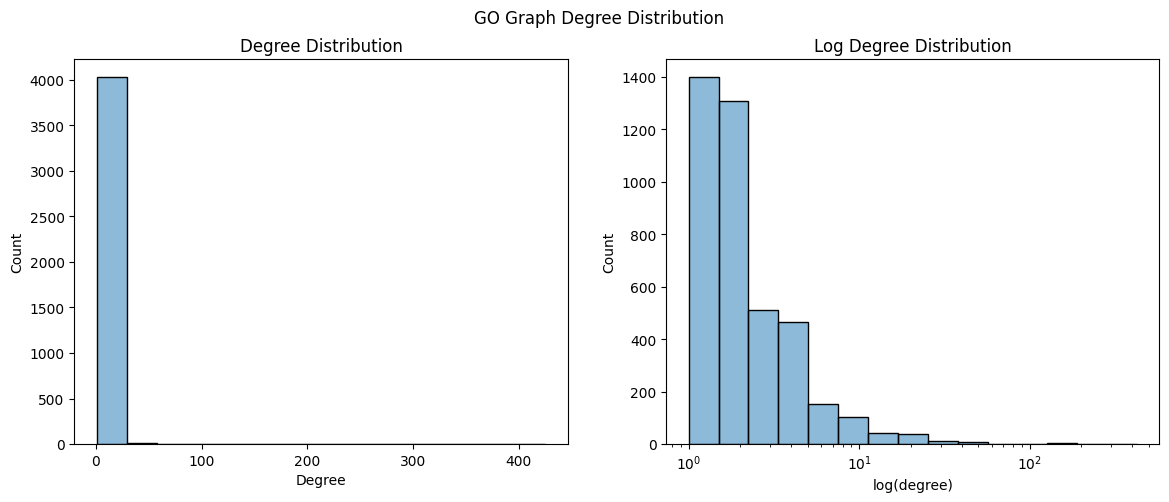

In [39]:
# Cellular Component

print(
    f"CC sub-graph average degree: {(go_graph_cc.size() / go_graph_cc.order()):.2f}")

plot_hist_degree(go_graph_cc)


MF sub-graph average degree: 1.22


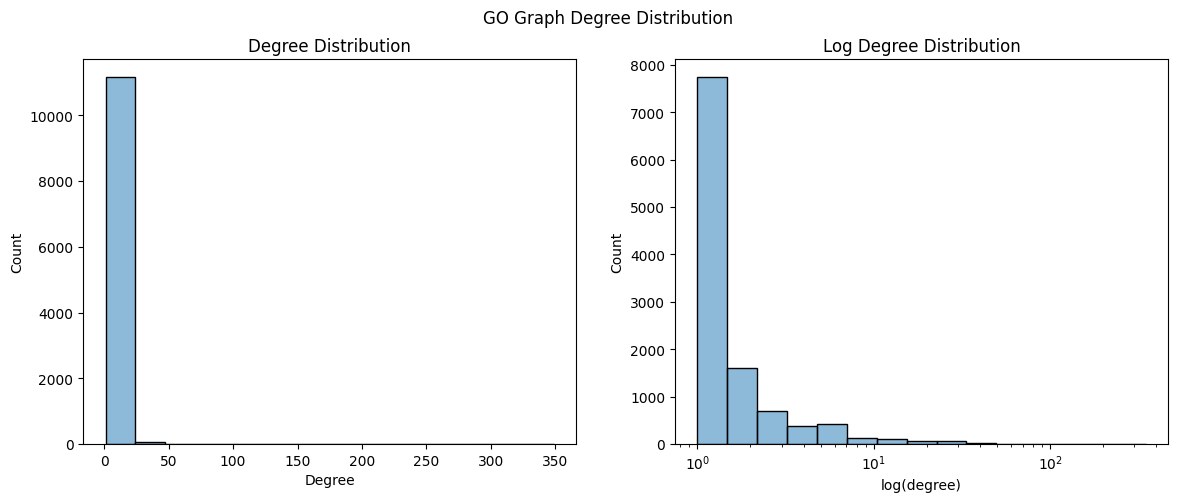

In [40]:
# Molecular Function

print(
    f"MF sub-graph average degree: {(go_graph_mf.size() / go_graph_mf.order()):.2f}")

plot_hist_degree(go_graph_mf)


BP sub-graph average degree: 2.31


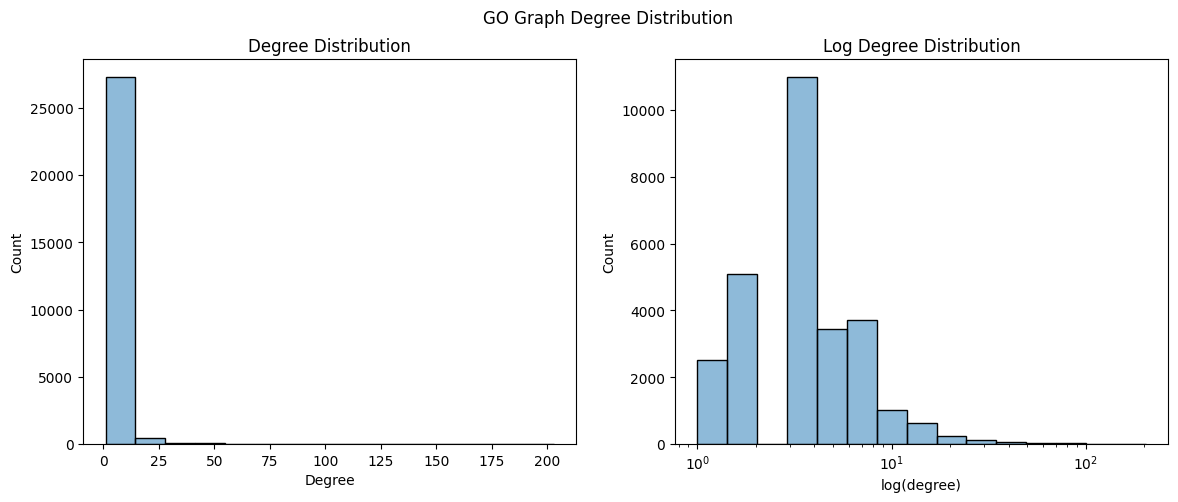

In [41]:
# Biological Process

print(
    f"BP sub-graph average degree: {(go_graph_bp.size() / go_graph_bp.order()):.2f}")

plot_hist_degree(go_graph_bp)


The degree distribution of the sub-ontologies Celullar Component and Molecular Function have fairly similar distributions. However, the nodes corresponding to Biological Process sub-ontology have predominance of degrees with higher degrees when compared to the CC and MF. The higher connectivity of BP's nodes could be due to the 'fuzziness' (I couldn't think of a word better than this) of this sub-ontology, where biological processes can be seen as pathways that are involved in cross-talk of enzimatic steps, or be associated to overlaping components of different pathways. For example, glucose metabolism is the entry-point for energy metabolism and the metabolites in the pathway are substrates for many biosynthetic reactions.

### Topological Generations of Sub-Ontologies

In [ ]:
print("Topological Generations -> Cellular Component")
print_generations(go_graph_cc)


In [ ]:
print("Topological Generations -> Molecular Function")
print_generations(go_graph_mf)


In [ ]:
print("Topological Generations -> Biological Process")
print_generations(go_graph_bp)


### Path Lengths

We can inspect the longest path length for each major sub-ontology as we did above for the complete GO graph:

In [45]:
print("GO terms in the longest path (order: terminal leaves -> root):")
print(f"Path length: {nx.dag_longest_path_length(go_graph_cc)}\n")

for item in nx.dag_longest_path(go_graph_cc):
    print(
        f"Name: {go_graph.nodes()[item]['name']} | Ontology: {go_graph.nodes()[item]['namespace']}"
    )

GO terms in the longest path (order: terminal leaves -> root):
Path length: 14

Name: PSII associated light-harvesting complex II, peripheral complex, LHCIIb subcomplex | Ontology: cellular_component
Name: PSII associated light-harvesting complex II, peripheral complex | Ontology: cellular_component
Name: PSII associated light-harvesting complex II | Ontology: cellular_component
Name: thylakoid light-harvesting complex | Ontology: cellular_component
Name: chloroplast thylakoid membrane protein complex | Ontology: cellular_component
Name: chloroplast thylakoid membrane | Ontology: cellular_component
Name: plastid thylakoid membrane | Ontology: cellular_component
Name: plastid membrane | Ontology: cellular_component
Name: plastid envelope | Ontology: cellular_component
Name: plastid | Ontology: cellular_component
Name: intracellular membrane-bounded organelle | Ontology: cellular_component
Name: intracellular organelle | Ontology: cellular_component
Name: intracellular anatomical structu

In [46]:
print("GO terms in the longest path (order: terminal leaves -> root):")
print(f"Path length: {nx.dag_longest_path_length(go_graph_mf)}\n")

for item in nx.dag_longest_path(go_graph_mf):
    print(
        f"Name: {go_graph.nodes()[item]['name']} | Ontology: {go_graph.nodes()[item]['namespace']}"
    )

GO terms in the longest path (order: terminal leaves -> root):
Path length: 12

Name: ryanodine-sensitive calcium-release channel activity involved in regulation of postsynaptic cytosolic calcium levels | Ontology: molecular_function
Name: ryanodine-sensitive calcium-release channel activity | Ontology: molecular_function
Name: calcium-release channel activity | Ontology: molecular_function
Name: ligand-gated calcium channel activity | Ontology: molecular_function
Name: ligand-gated monoatomic cation channel activity | Ontology: molecular_function
Name: ligand-gated monoatomic ion channel activity | Ontology: molecular_function
Name: monoatomic ion gated channel activity | Ontology: molecular_function
Name: monoatomic ion channel activity | Ontology: molecular_function
Name: channel activity | Ontology: molecular_function
Name: passive transmembrane transporter activity | Ontology: molecular_function
Name: transmembrane transporter activity | Ontology: molecular_function
Name: transpor

In [47]:
print("GO terms in the longest path (order: terminal leaves -> root):")
print(f"Path length: {nx.dag_longest_path_length(go_graph_bp)}\n")

for item in nx.dag_longest_path(go_graph_bp):
    print(
        f"Name: {go_graph.nodes()[item]['name']} | Ontology: {go_graph.nodes()[item]['namespace']}"
    )

GO terms in the longest path (order: terminal leaves -> root):
Path length: 18

Name: activation of meiosis I spindle assembly checkpoint | Ontology: biological_process
Name: positive regulation of meiosis I spindle assembly checkpoint | Ontology: biological_process
Name: regulation of meiosis I spindle assembly checkpoint | Ontology: biological_process
Name: meiosis I spindle assembly checkpoint signaling | Ontology: biological_process
Name: meiotic spindle assembly checkpoint signaling | Ontology: biological_process
Name: meiotic spindle checkpoint signaling | Ontology: biological_process
Name: negative regulation of metaphase/anaphase transition of meiotic cell cycle | Ontology: biological_process
Name: regulation of metaphase/anaphase transition of meiotic cell cycle | Ontology: biological_process
Name: regulation of meiotic chromosome separation | Ontology: biological_process
Name: meiotic chromosome separation | Ontology: biological_process
Name: meiotic chromosome segregation | 

### Visualization

We can plot the graph to grasp its general aspects. However, graphs for machine learning applications are usually large and plotting all nodes and edges can be computionally expensive and somewhat useless. The custom function `plot_graph` can be used with a list of nodes, and we will be plotting the nodes with the highest degree. The function plots nodes' sizes and transparencies (*alpha*) according to its relative degree. We need to select a subset of the nodes because the GO graph is huge and would take a lot of time to plot and vizualization can be dificult. Another parameter is to set the number of iterations to determine the best distance between nodes. The [spring_layout](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html) algorithm of NetworkX treats edges as springs bringing nodes together, and nodes has repelling objects. The simulation usually stops when these forces (and positions) are close to the equilibrium or until reach the number of iterations we define.

Let's plot the sub-ontologies graphs:

Plotting subgraph with 200 nodes and 272 edges...


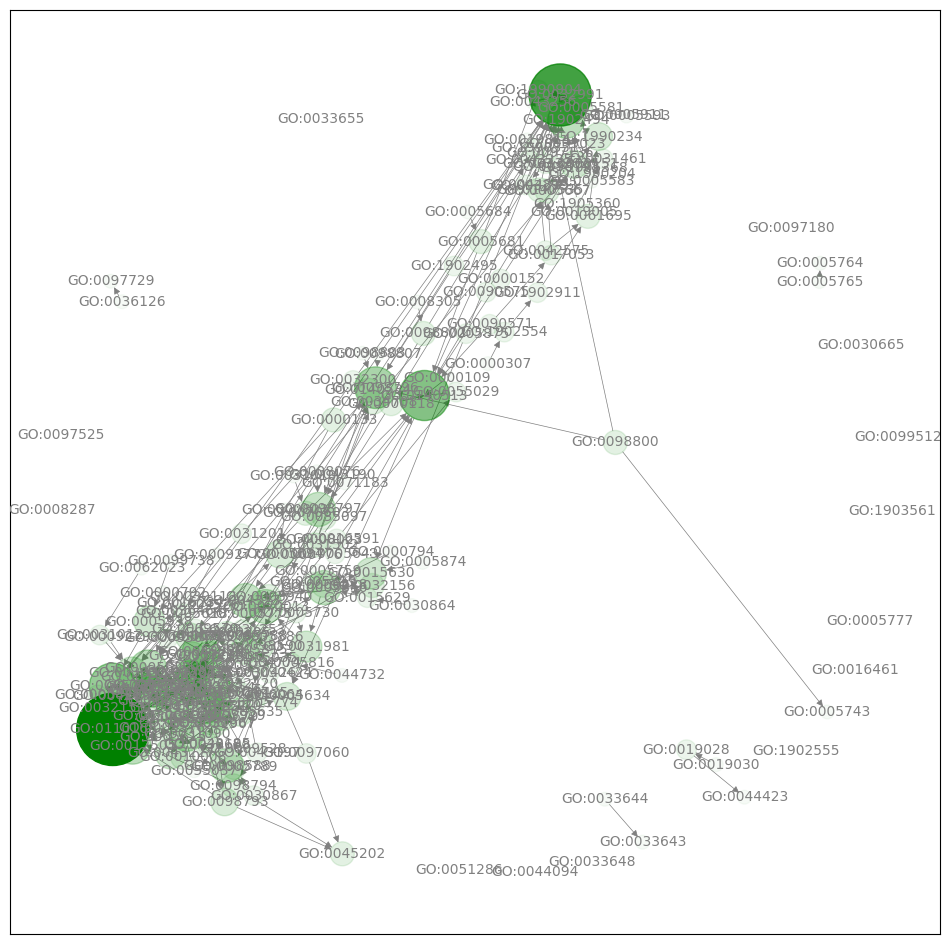

In [48]:
# Cellular Component network plot (highest degrees)

plot_graph(
    go_graph_cc,
    plot_all=False,
    plot_nodes=[
        x[0] for x in sorted(go_graph_cc.degree, key=lambda x: x[1], reverse=True)
    ],
    num_nodes=200,
    iterations=1000,  # increase iterations to optimize nodes' distances
)


Plotting subgraph with 200 nodes and 145 edges...


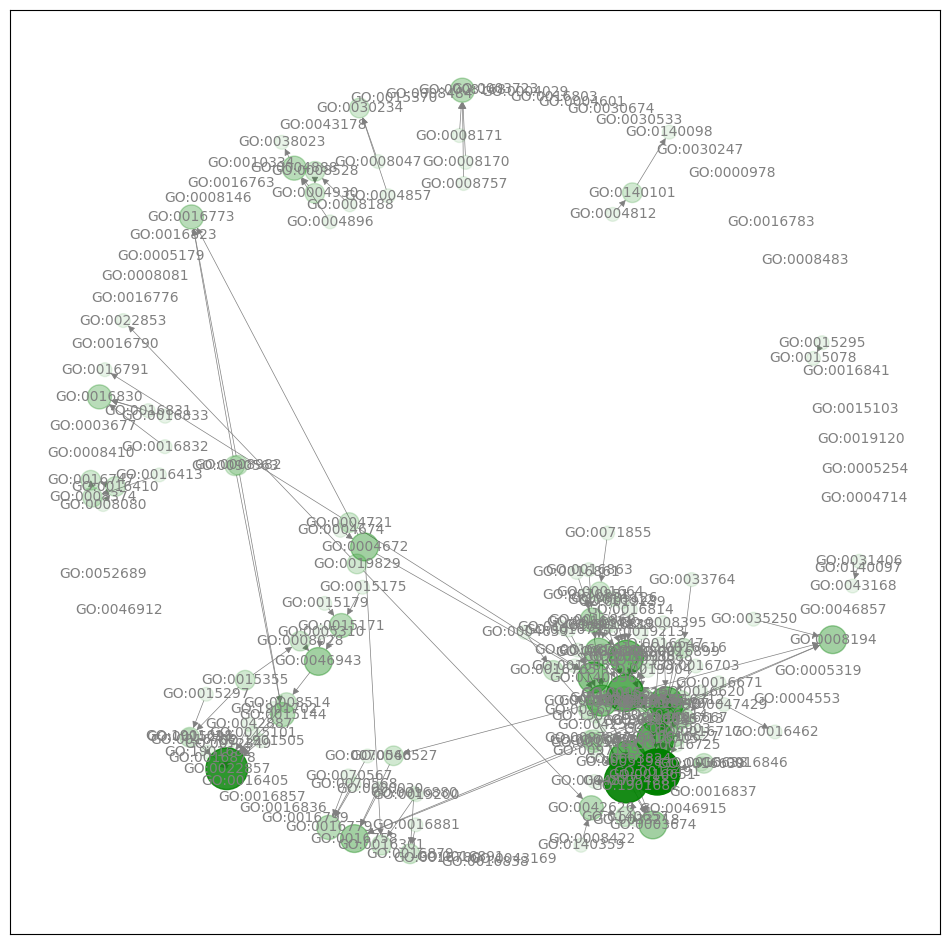

In [49]:
# Molecular Function network plot (highest degrees)

plot_graph(
    go_graph_mf,
    plot_all=False,
    plot_nodes=[
        x[0] for x in sorted(go_graph_mf.degree, key=lambda x: x[1], reverse=True)
    ],
    num_nodes=200,
    iterations=1000,  # increase iterations to optimize nodes' distances
)


Plotting subgraph with 200 nodes and 292 edges...


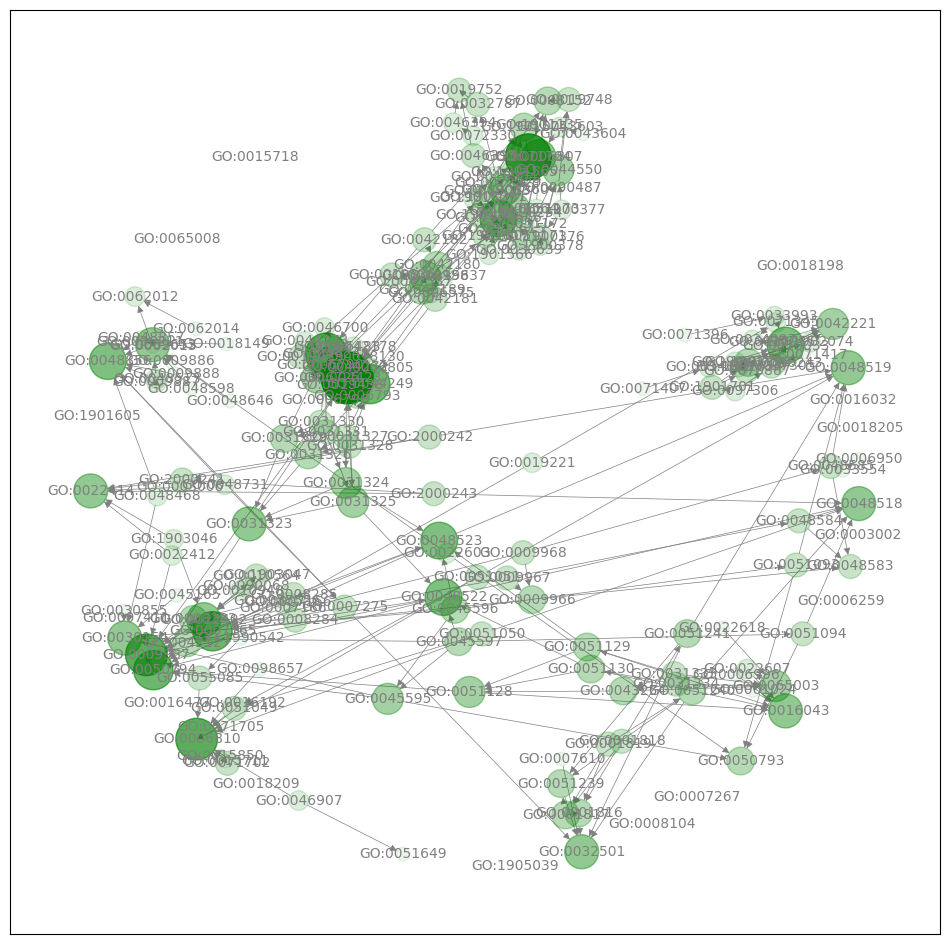

In [50]:
# Biological Process network plot (highest degrees)

plot_graph(
    go_graph_bp,
    plot_all=False,
    plot_nodes=[
        x[0] for x in sorted(go_graph_bp.degree, key=lambda x: x[1], reverse=True)
    ],
    num_nodes=200,
    iterations=1000,  # increase iterations to optimize nodes' distances
)


The GO graph has information about the GO terms stored in the nodes as attributes, as well as the type of relations between the nodes. We can access these attributes by specifying the GO term as key in the graph.nodes() object.

### Converting the GO terms attributes into a Pandas Dataframe

You might want to extract GO graph attributes into a dataframe. Dataframes are commom data structures in machine learning and are easier to manipulate and analyze because there are plenty of libraries and snipets to help in this task. We lose the topological information about the data but manipulating the dataset with Pandas can be useful (and easier) sometimes. Just a few lines of code do the job:

In [51]:
import pandas as pd

# creating a list with GO term definitions (the magic of list comprehension)
go_def_list = [go_graph.nodes()[term] for term in go_graph.nodes()]

# add features
go_df = pd.DataFrame.from_dict(go_def_list, orient="columns")

# insert column with GO term IDs (ordered)
go_df.insert(0, "go_term", list(go_graph.nodes()))

print(f"GO dataframe shape: {go_df.shape}")
go_df.head()

GO dataframe shape: (43248, 11)


,go_term,name,namespace,def,synonym,is_a,alt_id,subset,xref,relationship,comment
0,GO:0000001,mitochondrion inheritance,biological_process,"""The distribution of mitochondria, including t...","[""mitochondrial inheritance"" EXACT []]","[GO:0048308, GO:0048311]",NaN,NaN,NaN,NaN,NaN
1,GO:0000002,mitochondrial genome maintenance,biological_process,"""The maintenance of the structure and integrit...",NaN,[GO:0007005],NaN,NaN,NaN,NaN,NaN
2,GO:0000003,reproduction,biological_process,"""The production of new individuals that contai...","[""reproductive physiological process"" EXACT []]",[GO:0008150],"[GO:0019952, GO:0050876]","[goslim_agr, goslim_chembl, goslim_flybase_rib...",[Wikipedia:Reproduction],NaN,NaN
3,GO:0000006,high-affinity zinc transmembrane transporter a...,molecular_function,"""Enables the transfer of zinc ions (Zn2+) from...","[""high affinity zinc uptake transmembrane tran...",[GO:0005385],NaN,NaN,NaN,NaN,NaN
4,GO:0000007,low-affinity zinc ion transmembrane transporte...,molecular_function,"""Enables the transfer of a solute or solutes f...",NaN,[GO:0005385],NaN,NaN,NaN,NaN,NaN


Looking at the definition of GO terms, we see that 'name', 'namespace' and 'def' are commont to all GO term nodes, but there are more items in the GO terms nodes that are not. These will result in NaN (Not a Number) in the dataframe. We can get rid of it or replace by a more useful value. We can also add other informations to the dataframe such as degrees of nodes, embeddings of the text information (the term definitions, for example), or we can also merge other gene or protein-related datasets such as from BioGRID (protein-protein interactions) or UniProt (functional annotation of proteins)...

## Conclusion

Good data visualization techniques can be unusual sometimes, but these can also provide interesting insights on the data. There are many tools that can be match and mixed together to derive useful techniques to obtain key insights and features hidden amongst samples and variables.